# Clustering
The feature data used for this analysis is from the Formula 1 race, which have features such as driver, constructor, circuit, the stops driver make in one race, their pit stop time, and their final positio in that race. All these features include almost factors that could affects the final position result for a driver. 

Each driver got differnt strategy of pit stop frequency and time in different races, predicting their final position would be an enormous workload, therefore, we need to get some basic informations about the relationship among those features that could affect the final position for a driver. By excluding the 'position' column from our clustering, we can infer which feature may correlate with dirver success and then help a certain driver to improve their position in a race in the following analysis.

# Packages

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.impute import SimpleImputer
import sklearn.cluster
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage



# EDA

In [18]:
results = pd.read_csv('Data/results.csv')
mergedPitStops = pd.read_csv('Data/mergedPitStops.csv')

In [19]:
data = pd.merge(mergedPitStops,results[['driverId', 'position']], left_on = 'driverId', right_index = True, how = 'left')

/var/folders/j9/cbm31jzn08z95c3hz67rzjyc0000gn/T/ipykernel_54520/367688774.py:1: FutureWarning: Passing 'suffixes' which cause duplicate columns {'driverId_x'} in the result is deprecated and will raise a MergeError in a future version.
  data = pd.merge(mergedPitStops,results[['driverId', 'position']], left_on = 'driverId', right_index = True, how = 'left')


In [20]:
column_to_move = data.pop('position')
data.insert(2, 'position', column_to_move)
data = data.replace('\\N', pd.NA)
data = data.dropna()

In [32]:
selected_columns = ['driverId_x', 'stop', 'position', 'seconds', 'circuitId_x', 'constructorId_x']
selected_df = data[selected_columns]
selected_df.head()

,driverId_x,driverId_x,stop,position,seconds,circuitId_x,constructorId_x
0,153,153,1,6,26.898,17.0,5
1,153,153,2,6,24.463,17.0,5
2,153,153,3,6,26.348,17.0,5
6,4,4,1,5,23.251,17.0,6
7,4,4,2,5,24.733,17.0,6


# Clustering - Record Data

In [33]:
# We will drop the 'position' column as it represent a label
clustering_df = selected_df.drop(columns = ['position']).dropna()

In [34]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_df)

In [47]:
# RETURN THE CLUSTER RESULT THAT OPTIMIZES THE SILHOUETTE SCORE
def maximize_silhouette(X, algo = "birch", nmax = 20, i_plot = False):

    # PARAM
    i_print = False

    #FORCE CONTIGUOUS
    X = np.ascontiguousarray(X)

    # LOOP OVER HYPER-PARAM
    params = []; sil_scores = []
    sil_max = -10
    for param in range(2,nmax+1):
        if(algo == "birch"):
            model = sklearn.cluster.Birch(n_clusters = param).fit(X)
            labels = model.predict(X)

        if(algo == "ag"):
            model = sklearn.cluster.AgglomerativeClustering(n_clusters = param).fit(X)
            labels = model.labels_

        if(algo == "dbscan"):
            param = 0.25*(param-1)
            model = sklearn.cluster.DBSCAN(eps = param).fit(X)
            labels = model.labels_

        if(algo == "kmeans"):
            model = sklearn.cluster.KMeans(n_clusters = param).fit(X)
            labels = model.predict(X)

        try:
            sil_scores.append(sklearn.metrics.silhouette_score(X,labels))
            params.append(param)
        except:
            continue

        if(i_print): print(param,sil_scores[-1])

        if(sil_scores[-1] > sil_max):
             opt_param = param
             sil_max = sil_scores[-1]
             opt_labels = labels

    print("OPTIMAL PARAMETER =", opt_param)

    if(i_plot):
        fig, ax = plt.subplots()
        ax.plot(params, sil_scores, "-o")
        ax.set(xlabel = 'Hyper-parameter', ylabel='Silhouette')
        plt.show()

    return opt_labels


## K-Means Clustering

K-means is a method that used to classify a set of points into K distinct non-overlapping clusters where each point belongs to the cluster with the nearest mean. In general, if we want to split points on a paper into 3 K-means groups, we would iteritively try to put all nearby points into one group that all points in this group are sharing some same patterns. The iteration will continuing untile it finds the best cluster classification.

Meanwhile, we could use the Elbow and Silhouette method to evaluate how well the cluster classification is. For example, we can use Elbow method to see where the improvments in grouping points start to diminish therefore find the optimal parameters or features that are suitable for our analysis. Also we can use Silhouette method to give a score on our clusters where higher score represents a well classified cluster.

In [35]:
kmeans = KMeans(n_clusters = 6, random_state = 82)
kmeans_labels = kmeans.fit_predict(scaled_data)

/Users/kai/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Elbow Method

In [53]:
inertia_values = []
clusters_range = range(1, 11)
for n_clusters in clusters_range:
    kmeans = KMeans(n_clusters = n_clusters, random_state = 27)
    kmeans.fit(scaled_data)
    inertia_values.append(kmeans.inertia_)

distortion_values = [inertia/len(scaled_data) for inertia in inertia_values]
df_inertia = pd.DataFrame({'Number of Clusters': clusters_range, 'Distortion': distortion_values, 'Inertia': inertia_values})
df_inertia

/Users/kai/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/kai/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/kai/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/kai/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/kai/anaconda3/lib/pyt

,Number of Clusters,Distortion,Inertia
0,1,6.000000,28386.000000
1,2,3.921984,18554.906181
2,3,3.051876,14438.424935
3,4,2.505540,11853.710351
4,5,2.161148,10224.389887
5,6,1.687112,7981.726708
6,7,1.424744,6740.461687
7,8,1.213436,5740.763534
8,9,1.058498,5007.753693
9,10,0.968158,4580.355328


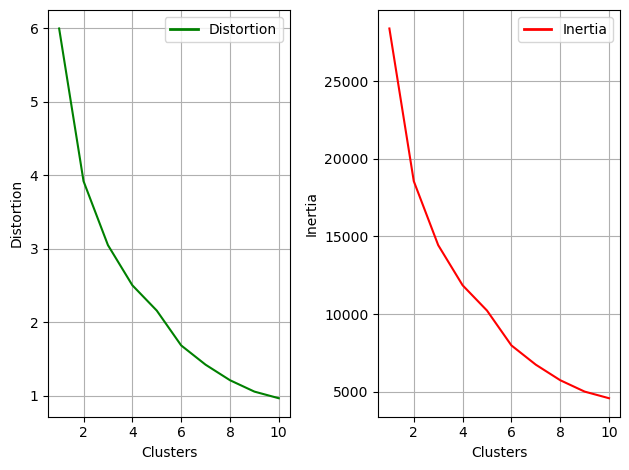

In [54]:
fig, ax = plt.subplots(1, 2)

# Distortion plot
ax[0].plot(df_inertia['Number of Clusters'], df_inertia['Distortion'], color = 'g')
ax[0].set_xlabel('Clusters')
ax[0].set_ylabel('Distortion')
ax[0].legend(handles = [plt.Line2D([0], [0], color = 'g', lw = 2, label = 'Distortion')],loc = 'best')
ax[0].grid(True)

# Inertia plot
ax[1].plot(df_inertia['Number of Clusters'], df_inertia['Inertia'], color = 'r')
ax[1].set_xlabel('Clusters')
ax[1].set_ylabel('Inertia')
ax[1].legend(handles = [plt.Line2D([0], [0], color = 'r', lw = 2, label = 'Inertia')],loc = 'best')
ax[1].grid(True)

plt.tight_layout()
plt.show()

The result showed by the Elbow method is not clear and quite hard to tell where should cut from the clusters. Therefore, this method is assumptively not suitable for this dataset to use. 

### Silhouette Method

/Users/kai/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/kai/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/kai/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/kai/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/kai/anaconda3/lib/pyt

OPTIMAL PARAMETER = 4


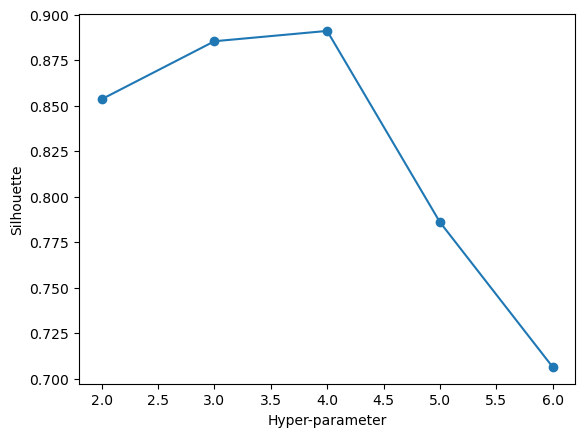

In [49]:
opt_labels = maximize_silhouette(clustering_df, algo = "kmeans", nmax = 6, i_plot = True)
plt.show()

The Silhouette method take 4 as the optimal parameter.

## DBSCAN Clustering

DBSCAN Clustering is density based clustering method that use the point neighbor density to decide the cluster. Then this cluster will keep looking for points that have the similar neighbor density as itself. In the end, points that does not belong to any density cluster will considered as noise.  

OPTIMAL PARAMETER = 4.75


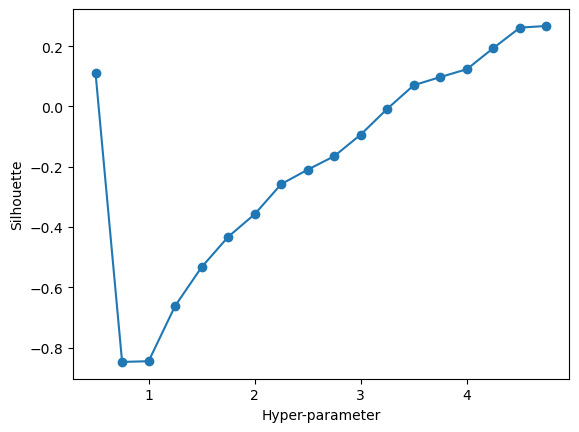

In [42]:
opt_labels = maximize_silhouette(clustering_df, algo = "dbscan", nmax = 20, i_plot = True)
plt.show()

The DBSCAN method takes 4.75 as the optimal parameter which is approaching the result of 4 from the Silhouette method

## Hierarchical Clustering

We could consider the Hierarchical Clustering as a type of tree on some level that points are absorbed into a group gradually and therefore create a link in the way of a dendrogram diagram. We can look at the dendrogram to decide where to 'cut' the tree to get a good number of clusters

OPTIMAL PARAMETER = 4


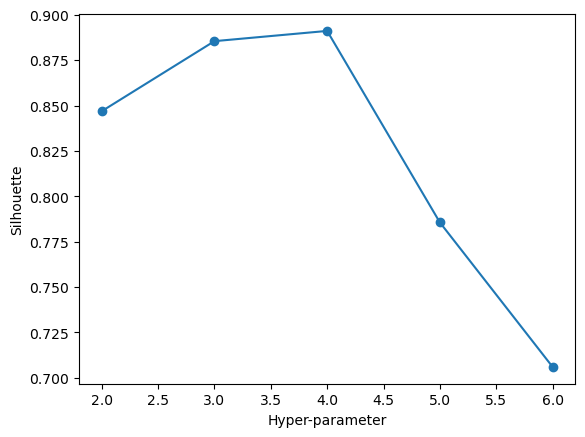

In [46]:
opt_labels = maximize_silhouette(clustering_df, algo = "ag", nmax = 6, i_plot= True)
plt.show()

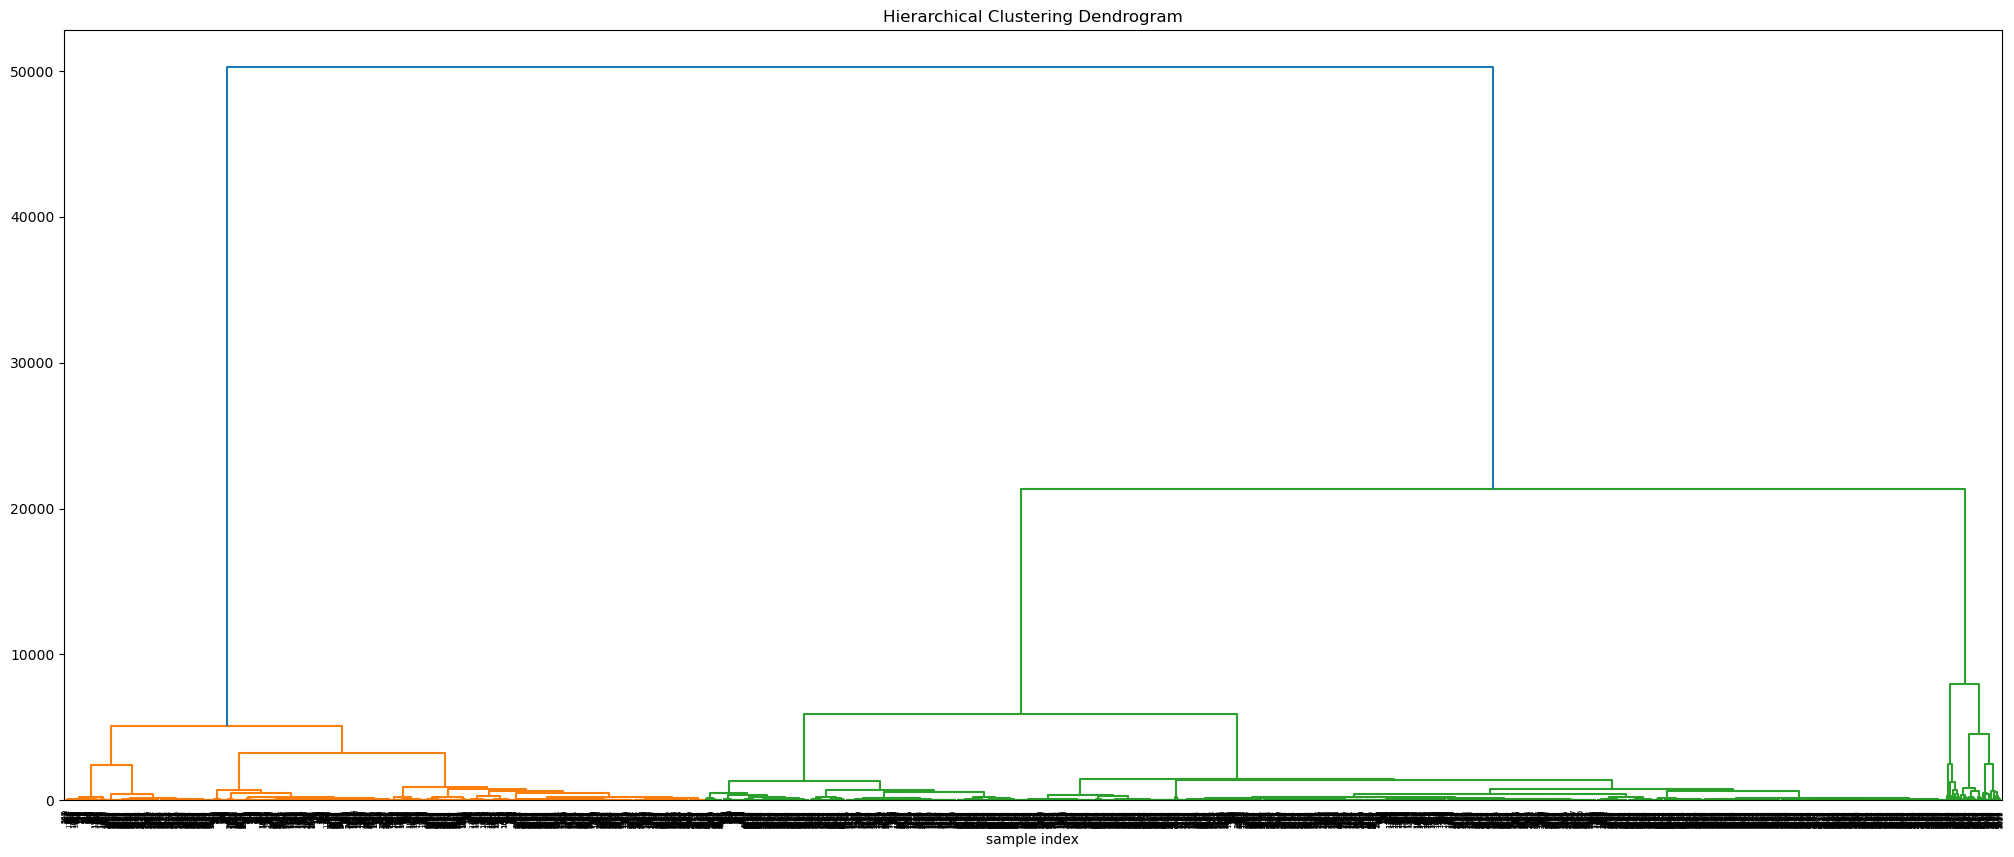

In [59]:
Z = linkage(clustering_df, method = 'ward')  # You can change 'ward' to other methods: 'single', 'complete', 'average', ...

# Plot the dendrogram
plt.figure(figsize = (25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
dn = dendrogram(Z)
plt.show()

# Summary
K-means seems is the best clustering algorithm for this datset since it got the result of k = 4 is the optimal value. Therefore, this datset should be split into 4 clusters which could affect the final position result for a driver the most. We could use this information in following analysis to help the driver improve their race position.